# URL Classification Neural Network

### Imports and Getting Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

I used the dataset_small because it has a similar number of phishing vs non-phishing URLs

In [2]:
URL_data = pd.read_csv(
    'https://github.com/GregaVrbancic/Phishing-Dataset/raw/master/dataset_small.csv',
    sep=',', encoding='latin-1')

# get rid of the unnecessary domain special characters features
data = URL_data.drop(["qty_slash_domain","qty_questionmark_domain","qty_equal_domain","qty_and_domain","qty_exclamation_domain","qty_space_domain","qty_tilde_domain","qty_comma_domain","qty_plus_domain","qty_asterisk_domain","qty_hashtag_domain","qty_dollar_domain","qty_percent_domain"], axis=1)

display(data)
print(data.shape)

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,1,2,1,389,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,1,0,0,5,0,1,0,0,0,0,...,1,2,2,563,0,0,0,0,0,1
58641,2,0,0,0,0,0,0,0,0,0,...,1,4,0,122,1,0,0,0,0,0
58642,5,6,3,6,0,2,1,1,0,0,...,1,2,1,1122,0,0,0,0,0,1
58643,2,0,0,0,0,0,0,0,0,0,...,5,2,5,299,1,1,0,0,0,0


(58645, 99)


### Simple Feature Engineering

In [3]:
# target and show only correlations with phishing
URL_corr = data.corr()[['phishing']]

# create a table of features and their correlation values beyond +-0.25
corr_positive_filtered = URL_corr[URL_corr['phishing'] > 0.25]
corr_negative_filtered = URL_corr[URL_corr['phishing'] < -0.25]

corr_filtered = pd.concat([corr_positive_filtered, corr_negative_filtered])

display(corr_filtered.head())


,phishing
qty_slash_url,0.598533
length_url,0.381858
qty_dot_directory,0.570226
qty_hyphen_directory,0.300448
qty_underline_directory,0.473611


In [4]:
# list of features with those target correlation values
features = list(corr_filtered.index)

print(features)
print(len(features))

['qty_slash_url', 'length_url', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory', 'directory_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'qty_questionmark_params', 'qty_at_params', 'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params', 'tld_present_params', 'phishing', 'time_domai

<Axes: >

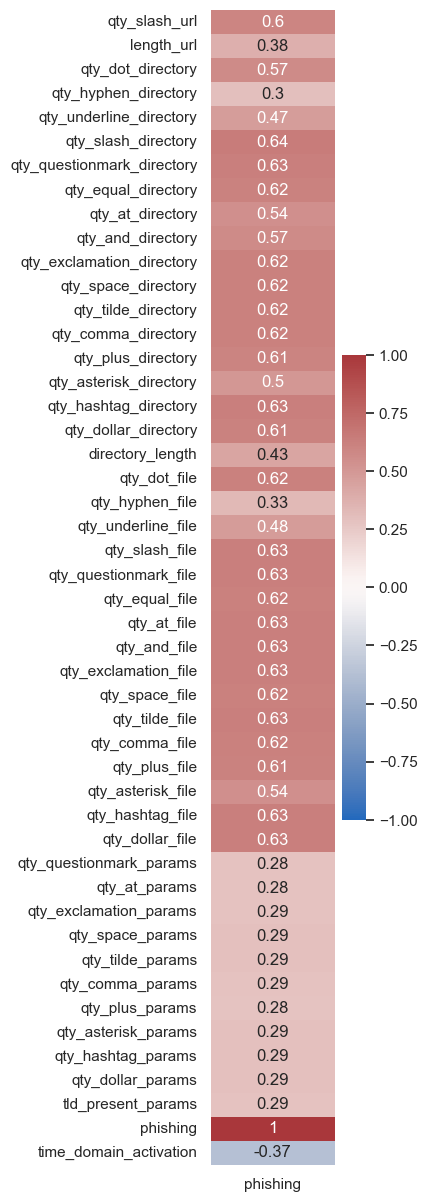

In [5]:
# showing the correlation values for those target features
sns.set(rc={'figure.figsize':(2,15)})
sns.heatmap(corr_filtered, vmin=-1, cmap="vlag", annot=True)

### Preparing Data

In [6]:
# keep only the intended features
data = data[features]

display(data.head())

,qty_slash_url,length_url,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,...,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,tld_present_params,phishing,time_domain_activation
0,0,14,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,0,4927
1,2,38,0,0,0,2,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,0,8217
2,1,24,0,0,0,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,0,258
3,3,38,0,0,0,3,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,1,2602
4,4,46,0,0,0,4,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


In [7]:
# randomize the rows, just for good practice

data = data.sample(frac=1, random_state=0).reset_index(drop=True)

# split the data into the features and label

X = data.drop("phishing", axis=1)
Y = data["phishing"]

display(X.head())
print(Y.head())

,qty_slash_url,length_url,qty_dot_directory,qty_hyphen_directory,qty_underline_directory,qty_slash_directory,qty_questionmark_directory,qty_equal_directory,qty_at_directory,qty_and_directory,...,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,tld_present_params,time_domain_activation
0,5,68,0,5,0,5,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,24,0,0,0,2,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,119
2,1,13,0,0,0,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,517
3,4,60,0,0,0,4,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1420
4,3,45,0,0,0,3,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


0    0
1    1
2    1
3    1
4    1
Name: phishing, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

### Training the model

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# single run neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.AUC()])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy, auc = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

Epoch 1/10
1320/1320 [==============================] - 1s 599us/step - loss: 0.3038 - accuracy: 0.8736 - auc: 0.9422 - val_loss: 0.2865 - val_accuracy: 0.8789 - val_auc: 0.9490
Epoch 2/10
1320/1320 [==============================] - 1s 533us/step - loss: 0.2833 - accuracy: 0.8808 - auc: 0.9497 - val_loss: 0.2950 - val_accuracy: 0.8757 - val_auc: 0.9523
Epoch 3/10
1320/1320 [==============================] - 1s 532us/step - loss: 0.2756 - accuracy: 0.8818 - auc: 0.9523 - val_loss: 0.2703 - val_accuracy: 0.8811 - val_auc: 0.9552
Epoch 4/10
1320/1320 [==============================] - 1s 529us/step - loss: 0.2673 - accuracy: 0.8860 - auc: 0.9551 - val_loss: 0.2585 - val_accuracy: 0.8870 - val_auc: 0.9586
Epoch 5/10
1320/1320 [==============================] - 1s 531us/step - loss: 0.2607 - accuracy: 0.8888 - auc: 0.9572 - val_loss: 0.2527 - val_accuracy: 0.8866 - val_auc: 0.9598
Epoch 6/10
1320/1320 [==============================] - 1s 529us/step - loss: 0.2538 - accuracy: 0.8920 - auc:

**What ChatGPT has to say about improving this model:**

1. Increase the model complexity: If your current model is not capturing the complexity of the data well enough, you can increase the number of hidden layers, increase the number of units in each layer, or both. This allows the model to learn more intricate patterns and relationships in the data. However, be cautious not to make the model too complex, as it may lead to overfitting.

2. Normalize or standardize the input data: Normalize or standardize the input features to have zero mean and unit variance. This can help the model converge faster and improve its performance. You can use the StandardScaler from scikit-learn to standardize the numerical features.

3. Feature engineering: Analyze and preprocess your features to extract more meaningful information. You can try creating new features or transforming existing ones to better represent the underlying patterns in the data. Feature engineering techniques such as one-hot encoding, polynomial features, or interaction terms may be beneficial.

4. Regularization: Apply regularization techniques to prevent overfitting. Regularization methods like L1 or L2 regularization (via the kernel_regularizer parameter in Keras) can help reduce the model's reliance on specific features and improve its generalization ability.

5. Hyperparameter tuning: Experiment with different hyperparameters to find the optimal configuration for your model. You can adjust the learning rate, batch size, number of epochs, optimizer choice, and other hyperparameters. Consider using techniques like grid search or random search to efficiently explore the hyperparameter space.

6. Increase the amount of training data: Obtaining more training data can help the model learn more robust representations and generalize better. If feasible, try to collect more labeled samples or consider data augmentation techniques to generate additional training examples.

7. Regularize with dropout: Dropout is a regularization technique that randomly sets a fraction of input units to 0 at each update during training. It helps prevent overfitting by reducing the reliance of the model on specific neurons. You can apply dropout by adding keras.layers.Dropout layers between your hidden layers.

8. Consider using different activation functions: Experiment with different activation functions, such as LeakyReLU or ELU, to see if they improve the model's performance. Different activation functions can affect how the model learns and can be more suitable for certain problem domains.